# CSCI 635 - Introduction to Machine learning - Unsupervised learning - Group 6

The following notebook discusses the training of neural networks to be able to perform sentiment analysis over a input review of video game. 

In [1]:
# Importing the libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import string
import re
import time
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
# Importing the dataset

dataset = pd.read_csv("Video_Games_CSV.csv")

dataset.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1.0,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,DIRT 3,1308009600,"06 14, 2011"


The text data preprocessing utility functions are mentioned below:

In [3]:
"""
A utility function to remove non alphabetical characters from the text.

"""

def clean_noncharacters(text):
    # Removing punctuations
    text  = "".join([char for char in text if char not in string.punctuation])
    # Removing numerics
    text = re.sub('[0-9]+', '', text)
    return text


"""
A utility function to remove URL links from the text.

"""

def clean_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove stopwords from the text.

"""

def clean_stopwords(text):
    stop_words = set(stopwords.words('english'))
    res = [w for w in text.split() if not w in stop_words]
    res_string = " ".join(str(x) for x in res)
    return res_string

In [4]:
# Apply above preprocessing methods to the dataset

dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_noncharacters(str(x)))
dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_URL(str(x)))
dataset["reviewText"] = dataset["reviewText"].apply(lambda x : clean_stopwords(str(x)))

dataset.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing game struggle games windows live bu...,1.0,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If like rally cars get game funIt oriented Eur...,4.0,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",st shipment received book instead gamend shipm...,1.0,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]",I got version instead PS version turned mistak...,3.0,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I Dirt Xbox okay game I started playing games ...,4.0,DIRT 3,1308009600,"06 14, 2011"


As studied previously, not all reviews have numeric overall rating class. Some have textual classes as well. So we eliminate those reviews from our training process:

In [5]:
# Removing the rows with "overall" values not in range 1.0-5.0

dataset = dataset[dataset['overall'].apply(lambda x: x in ["1.0", "2.0", "3.0", "4.0", "5.0"])]

Removing all the columns which do not play role in training of the network.

In [6]:
# Shortening the dataset by removing all the columns except reviewText and overall

dataset_short = dataset[["reviewText","overall"]].copy()

In [7]:
X = dataset_short.reviewText[0:2500]
Y = dataset_short.overall[0:2500]

In [9]:
def cleaningData(text):
    cleanText = []
    for sent in text:
    	if type(sent) == float:
    		continue
    	words = sent.split()
    	table = str.maketrans("","",string.punctuation)
    	stripped = [w.translate(table) for w in words]
    	words = [word.lower() for word in stripped]
    	sent = " ".join(words)
    	cleanText.append(sent)

    return cleanText
  
cleanText = cleaningData(X)
cleanText[0:5]

['installing game struggle games windows live bugssome championship races cars unlocked buying addon game i paid nearly dollars game new i dont like idea i keep paying keep playingi noticed improvement physics graphics compared dirt i tossed garbage vowed never buy another codemasters game im really tired arcade style rallyracing games anywayill continue get fix richard burns rally httpwwwamazoncomrichardburnsrallypcdpbcrefsrieutfqidsrkeywordsrichardburnsrallythank reading review if enjoyed sure rate helpful',
 'if like rally cars get game funit oriented european market since america isnt huge rally fan party music european even voices game english accentthe multiplayer isnt best works ok',
 'st shipment received book instead gamend shipment got fake one game arrived wrong key inside sealed box i got contact codemasters send pictures dvd content they said nothing fake dvdreturned good bye',
 'i got version instead ps version turned mistake console versions games look percent good pc ve

In [11]:
train_messages_tokens = []

avg_length = 0


for message in cleanText:
    tokens = message.split(" ")
    train_messages_tokens.append(tokens)
    avg_length += len(tokens)

start = time.time()

word2vec_model = Word2Vec(train_messages_tokens, min_count = 1)

end = time.time()

print("Word2Vec model generated successfully in {} seconds.".format(end - start))

Word2Vec model generated successfully in 1.2923665046691895 seconds.


In [13]:
def vectorize(text):
    text_vector = []
    num_words = 0
    for word in text:
        try:
            if num_words == 0:
                text_vector = word2vec_model[word]
            else:
                text_vector = np.add(text_vector, word2vec_model[word])
            num_words += 1
        except:
            print("Something went wrong while generating vectors.")
     
    return np.asarray(text_vector) / num_words


train_messages_vectors = []

start = time.time()

for train_token in train_messages_tokens: 
    vector = vectorize(train_token)
    train_messages_vectors.append(vector)
    
end = time.time()

print("Successfully generated vectors for all sentences in {} seconds.".format(end - start))

C:\Users\mehta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\mehta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


Successfully generated vectors for all sentences in 1.7764065265655518 seconds.


Text(0, 0.5, 'Frequency')

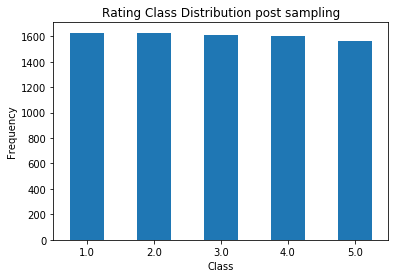

In [15]:
from imblearn.combine import SMOTETomek

Y = Y.to_list()
smk = SMOTETomek(random_state = 42)
text, label = smk.fit_sample(train_messages_vectors, Y)
countClasses2 = pd.value_counts(label, sort=True)
countClasses2.plot(kind='bar', rot=0)
plt.title("Rating Class Distribution post sampling")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [16]:
def clusterize_and_plot_inertia(data = train_messages_vectors, type="kmeans"):
    
    all_sizes = []
    all_inertias = []

    for i in range(2,7):
        num_clusters = i
        all_sizes.append(i)
        print("Cluster size: {}".format(i))
        start = time.time()

        cluster_model = None
        cluster_inertia = 0
    
        if(type == "kmeans"):
            cluster_model = KMeans(n_clusters = i, random_state = int("007")).fit(np.array(data))
            cluster_inertia = cluster_model.inertia_
            print("Cluster inertia computed: {}".format(cluster_inertia))
        if(type == "agglomerative"):
            cluster_model = AgglomerativeClustering(n_clusters = i).fit(np.array(data))
            cluster_inertia = cluster_model.inertia_
            print("Cluster inertia computed: {}".format(cluster_inertia))
            
        all_inertias.append(cluster_inertia)


    plt.figure(figsize = (10,5))
    plt.plot(all_sizes, all_inertias, color = "b")
    plt.title("Clustering model: {}. Inertia w.r.t. the cluster sizes".format(type[0].upper() + type[1:]))
    plt.xlabel("Cluster size")
    plt.ylabel("Inertia")
    plt.show()

In [17]:
def decompose(components, data, labels):
    axes = ['component_1','component_2']
    matrix = PCA(n_components=components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:axes[i] for i in range(components)}, axis=1, inplace=True)
    df_matrix['labels'] = labels

    return df_matrix

In [18]:
def clustering_KMeans(embedding, n_clusters):
  clusterModel = KMeans(n_clusters = n_clusters)
  clusterModel.fit(embedding)
  clusterAssignments = clusterModel.labels_

  pca_df = decompose(2, embedding, clusterAssignments)
  sns.scatterplot(x=pca_df.component_1, y=pca_df.component_2, hue = pca_df.labels, palette='Set1')
  plt.show()
  return clusterAssignments

Cluster size: 2
Cluster inertia computed: 2327.496796921805
Cluster size: 3
Cluster inertia computed: 1598.4772063170612
Cluster size: 4
Cluster inertia computed: 1224.0633099259453
Cluster size: 5
Cluster inertia computed: 1081.0484434277332
Cluster size: 6
Cluster inertia computed: 958.3006419824864


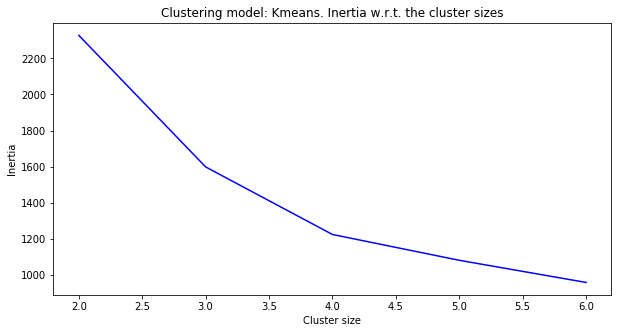

In [19]:
clusterize_and_plot_inertia(text, "kmeans")

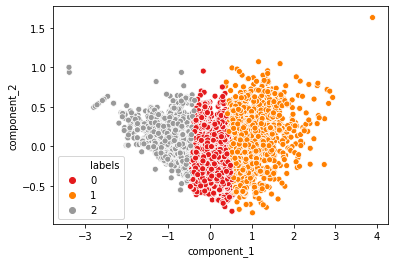

In [20]:
clusterAssignments = clustering_KMeans(text, 3)

In [26]:
def clustering_Agglomerative(embedding, n_clusters):
  clusterModel = AgglomerativeClustering(n_clusters=n_clusters)
  clusterModel.fit(embedding)
  agglomerative_assignments = clusterModel.labels_

  pca_df = decompose(2,embedding, agglomerative_assignments)
  sns.scatterplot(x=pca_df.component_1, y=pca_df.component_2, hue = pca_df.labels, palette='Set1')
  plt.show()
  return agglomerative_assignments

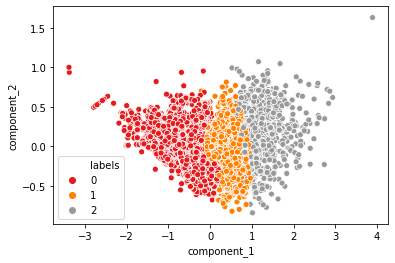

In [31]:
agglomerativeAssignments = clustering_Agglomerative(text, 3)

In [35]:
cluster = [[] for i in range(3)]
for i in range(len(cleanText)):
  cluster[clusterAssignments[i]].append(cleanText[i])

for i in range(3):
  print("Cluster ",i)
  for j in range(2):
    print(j+1,':',cluster[i][j])
  print("\n")

Cluster  0
1 : if like rally cars get game funit oriented european market since america isnt huge rally fan party music european even voices game english accentthe multiplayer isnt best works ok
2 : overall well done racing game good graphics time period my family enjoyed playing great deal i personally think steering wheel controller almost necessity game x box type controller would probably work the keyboard would almost impossible fun the windows live system detracts greatly since must log online play save game progress there mees live log game would longer accept activation code i rebuy game i wanted play there customer support dirt suffers serious flaw well star game star windows live feature


Cluster  1
1 : i dirt xbox okay game i started playing games laptop bought new games build collection this game fun play it much better dirt if like racing games check the graphics perfect compter
2 : i cant tell piece dog game like everything else microsoft makes doesnt work when going tak

In [36]:
cluster = [[] for i in range(3)]
for i in range(len(cleanText)):
  cluster[agglomerativeAssignments[i]].append(cleanText[i])

for i in range(3):
  print("Cluster ",i)
  for j in range(2):
    print(j+1,':',cluster[i][j])
  print("\n")

Cluster  0
1 : installing game struggle games windows live bugssome championship races cars unlocked buying addon game i paid nearly dollars game new i dont like idea i keep paying keep playingi noticed improvement physics graphics compared dirt i tossed garbage vowed never buy another codemasters game im really tired arcade style rallyracing games anywayill continue get fix richard burns rally httpwwwamazoncomrichardburnsrallypcdpbcrefsrieutfqidsrkeywordsrichardburnsrallythank reading review if enjoyed sure rate helpful
2 : if like rally cars get game funit oriented european market since america isnt huge rally fan party music european even voices game english accentthe multiplayer isnt best works ok


Cluster  1
1 : overall well done racing game good graphics time period my family enjoyed playing great deal i personally think steering wheel controller almost necessity game x box type controller would probably work the keyboard would almost impossible fun the windows live system detra